In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [25]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [26]:
device

device(type='cpu')

In [27]:
ticker = 'AAPL'
df = yf.download(ticker,'2020-01-01')

C:\Users\himan\AppData\Local\Temp\ipykernel_17912\1266454546.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [28]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620857,72.681304,71.373233,71.627107,135480400
2020-01-03,71.914803,72.676431,71.689942,71.847102,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146950,72.753831,71.926922,72.497537,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200
...,...,...,...,...,...
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600
2025-06-10,202.669998,204.350006,200.570007,200.600006,54672600


<Axes: xlabel='Date'>

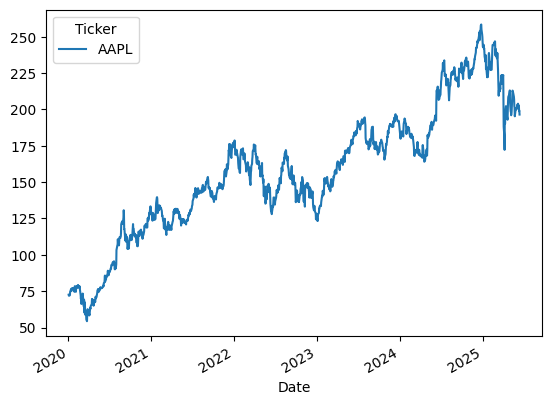

In [29]:
df.Close.plot()

In [30]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [31]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.909413
2020-01-03,-1.925323
2020-01-06,-1.912410
2020-01-07,-1.920092
2020-01-08,-1.893939
...,...
2025-06-09,0.993661
2025-06-10,1.021153
2025-06-11,0.933495


In [32]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)



In [33]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size,:-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)

In [39]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel,self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)

        out, (hn,cn) = self.lstm(x,(h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out

In [40]:
model = PredictionModel(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [41]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [43]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    if i % 25 == 0:
        print(i,loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.004030837211757898
25 0.0038393589202314615
50 0.0036816727370023727
75 0.003560344921424985
100 0.0034801564179360867
125 0.0034406750928610563
150 0.0034263699781149626
175 0.003732037730515003
